<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Лемматизатор-Wordnet-(с-тегом-POS)" data-toc-modified-id="Лемматизатор-Wordnet-(с-тегом-POS)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизатор Wordnet (с тегом POS)</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Раделим-датасет-на-выборки-и-векторизируем-тексты" data-toc-modified-id="Раделим-датасет-на-выборки-и-векторизируем-тексты-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Раделим датасет на выборки и векторизируем тексты</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#LGBMModel" data-toc-modified-id="LGBMModel-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LGBMModel</a></span></li><li><span><a href="#Тест" data-toc-modified-id="Тест-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Тест</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [10]:
# игнорирование предупреждений о несоответствии версий
import warnings
warnings.filterwarnings('ignore')

#  таблицы
import pandas as pd
import numpy as np
#!pip install tqdm

from tqdm.notebook import tqdm
tqdm.pandas()

#from pymystem3 import Mystem
import re

#штука для визуализации циклов
from tqdm import notebook

# стопслова и векторизация
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.corpus import stopwords as nltk_stopwords
# WORDNET LEMMATIZER (with appropriate pos tags)
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer

# модели
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMModel

# инструменты
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# # Install spaCy (run in terminal/prompt)
# import sys
# !{sys.executable} -m pip install spacy
# # Download spaCy's  'en' Model
# !{sys.executable} -m spacy download en_core_web_sm
# import spacy

[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Изучим датасет, посмотрим соотношение классов и наличие пропусков

In [11]:
url="https://code.s3.yandex.net/datasets/toxic_comments.csv"
data=pd.read_csv(url, index_col=0)

In [12]:
data.sample(10)

,text,toxic
30251,"""\nFine... I'm talking to the CDC directly. Y...",0
30379,"San Antonio, Texas \n\nPlease do not add comme...",0
25217,January 2015 (UTC)\nWould any of these be usea...,0
149684,Translation \n\nDoes anything get done here? I...,0
115987,don't worry you people won't have me to kick a...,0
104514,And yours is what? To disrupt? Make baseless a...,0
42888,This is not patent nonsense.\nI am not taking ...,0
138758,hey m00 \n\nyou are the worst,1
40328,Thankyou. I honestly think that you should soo...,0
75128,"""\n\n{{unblock|1=\nRuslik0 is incorrect in his...",0


In [13]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

In [14]:
data = data[0:1000]

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


### Лемматизация

In [160]:
#corpus = data['text'].values.astype('U')

### Лемматизатор Wordnet (с тегом POS)

In [16]:
# тихо ####### и ушел, называется нашел
 
lemmatizer = WordNetLemmatizer()
 
# Define function to lemmatize each word with its POS tag
 
# POS_TAGGER_FUNCTION : TYPE 1
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None
    
def pos(text):    
    
    # tokenize the sentence and find the POS tag for each token
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(text)) 
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
 
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
        # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:       
        # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
            
    return " ".join(lemmatized_sentence)

In [17]:
# Функция очистки текста от символов и цифр
def clear_text(text):
    text = re.sub(r'[^A-Za-zsS\']', ' ', text)
    return " ".join(text.split()).lower()

In [18]:
# сборка из списков в предложения
def join_text(text):
    return " ".join(text)

In [19]:
data['lemm'] = data['text'].progress_apply(clear_text)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
data['lemm'] = data['lemm'].progress_apply(pos)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
data = data.dropna()

In [76]:
data.head()

,text,toxic,lemm
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d'aww he match this background colour i 'm see...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i 'm really not try to edit war it 's ...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i ca n't make any real suggestion on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


In [6]:
# # Старый лемматайзер
# w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
# lemmatizer = nltk.stem.WordNetLemmatizer()

# def lemmatize_text(text):
#     return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

Ради интереса проверим, что вышло по итогу лемматизации

In [42]:
print(data['text'][8])
print()
print(data['lemm'][8])

Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169

sorry if the word 'nonsense ' be offensive to you anyway i 'm not intend to write anything in the article wow they would jump on me for vandalism i 'm merely request that it be more encyclopedic so one can use it for school as a reference i have be to the selective breeding page but it 's almost a stub it point to 'animal breed ' which be a short messy article that give you no info there must be someone around with expertise in eugenics


In [ ]:
# %%time
# # лемматизируем текст с помощью spaCy лематтизации
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# text = []
# #count = 0
# for i in notebook.tqdm(range(len(corpus))):
    
#     sentence = str(clear_text(corpus[i])).lower()
#     doc = nlp(sentence)
    
#     text.append(" ".join([token.lemma_ for token in doc]))
    
# #     count += 1
# #     if count == 1000:
# #          break

Загрузим стоп-слова для дальнейшей очистки текста

Сохраним таблицу на случай, проблем с Юпитером

In [ ]:
# data.to_csv('wikishop')

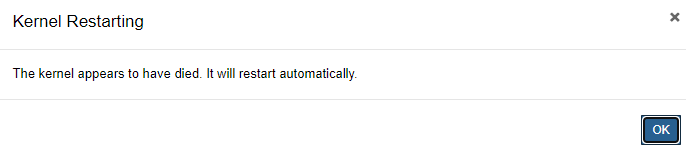

Это пригодилось, но даже с пропуском шага с лемматизацияей, система пребывает в агонии и отказывается считать дальше.

В виду отсутсвия доступа к чему-либо помимо яндексовского юпитера, который не может справиться с обработкой этого объёма данных и ломается даже при разделении датасета на выборки, принято решение применить даунсемплинг, возможно тогда юпитер сможет дожить до конца проекта

In [ ]:
# применим даунсемплинг, чтобы яндексовский юпитер смог это сожрать и перестал выдавать смерть
# def downsample(features, target, fraction):
#     features_zeros = features[target == 0]
#     features_ones = features[target == 1]
#     target_zeros = target[target == 0]
#     target_ones = target[target == 1]

#     features_downsampled = pd.concat(
#         [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
#     target_downsampled = pd.concat(
#         [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
#     features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
#     return features_downsampled, target_downsampled

# features_downsampled, target_downsampled = downsample(data['lemmatize'], data['toxic'], 0.5)

In [ ]:
# pd.Series(target_downsampled).value_counts()

По итогу, лемматизации с тегированием даёт более качественную лемматизацию, чем обычная. Экспериментально за кадром она прибавила к f1 0,01%

## Обучение

### Раделим датасет на выборки и векторизируем тексты

In [22]:
features = data['lemm'].values
target = data['toxic'].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=12345)

In [24]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf_train = count_tf_idf.fit_transform(X_train)
tf_idf_test = count_tf_idf.transform(X_test)

In [26]:
tf_idf_train.shape

(800, 6501)

In [27]:
tf_idf_test.shape

(200, 6501)

### Логистическая регрессия

In [75]:
lg = LogisticRegression(random_state=12345)

In [76]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

vect = CountVectorizer(stop_words=stopwords, binary=True)

tfidf = TfidfTransformer()

pipe = make_pipeline(vect, tfidf, lg)

In [77]:
pipe

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(binary=True,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('tfidftransformer', TfidfTransformer()),
                ('logisticregression', LogisticRegression(random_state=12345))])

In [79]:
distributions = {}
distributions['logisticregression__penalty'] = ['l2', 'l1']
distributions['countvectorizer__ngram_range'] = [(1,1), (1,2)]          
distributions['logisticregression__C'] = [0.1, 1, 10]

In [80]:
lg_grid = GridSearchCV(pipe, distributions, cv=3, verbose=2,
                                   scoring='f1', n_jobs=-1)

In [81]:
lg_grid.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END countvectorizer__ngram_range=(1, 1), logisticregression__C=0.1, logisticregression__penalty=l2; total time=   0.1s
[CV] END countvectorizer__ngram_range=(1, 1), logisticregression__C=0.1, logisticregression__penalty=l2; total time=   0.1s
[CV] END countvectorizer__ngram_range=(1, 1), logisticregression__C=0.1, logisticregression__penalty=l2; total time=   0.1s
[CV] END countvectorizer__ngram_range=(1, 1), logisticregression__C=0.1, logisticregression__penalty=l1; total time=   0.0s
[CV] END countvectorizer__ngram_range=(1, 1), logisticregression__C=0.1, logisticregression__penalty=l1; total time=   0.0s
[CV] END countvectorizer__ngram_range=(1, 1), logisticregression__C=0.1, logisticregression__penalty=l1; total time=   0.0s
[CV] END countvectorizer__ngram_range=(1, 1), logisticregression__C=1, logisticregression__penalty=l2; total time=   0.1s
[CV] END countvectorizer__ngram_range=(1, 1), logisticregression__C=1, lo

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(binary=True,
                                                        stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
      

In [82]:
lg_grid.best_score_

0.23095175896900036

In [164]:
lg = LogisticRegression(random_state=12345, class_weight='balanced')

In [170]:
distributions = {}
distributions['penalty'] = ['l2', 'l1']
distributions['C'] = [i for i in np.arange(2, 10, 0.5)]

In [171]:
lg_grid = GridSearchCV(lg, distributions, cv=3, verbose=2,
                                   scoring='f1', n_jobs=-1)

In [172]:
%%time
lg_grid.fit(tf_idf_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
CPU times: total: 16.5 s
Wall time: 1min 47s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=12345),
             n_jobs=-1,
             param_grid={'C': [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5,
                               7.0, 7.5, 8.0, 8.5, 9.0, 9.5],
                         'penalty': ['l2', 'l1']},
             scoring='f1', verbose=2)

In [173]:
lg_grid.best_params_

{'C': 8.5, 'penalty': 'l2'}

In [174]:
abs(lg_grid.best_score_)

0.7541397078629841

Линейная регрессия показала результат f-меры 0.75 при сбалансированном параметре весов. 

### LGBMModel

Сделаем скорер для того, чтобы модель могла оцениваться как бинарный классификатор.

In [185]:
def f1_sc(target, predict):
    train_preds = [1 if pred > 0.5 else 0 for pred in predict]
    return f1_score(target, train_preds)
f1 = make_scorer(f1_sc)

In [198]:
booster = LGBMModel(objective='binary', random_state=12345)

In [199]:
distributions = {}
distributions['n_estimators'] = [i for i in np.arange(150, 500, 15)]
distributions['max_depth'] = [None] + [i for i in range(1, 6)]
distributions['boosting'] = ['gbdt', 'rf', 'dart', 'goss']
#distributions['max_bin'] = [32, 64, 128]

In [200]:
booster_random = RandomizedSearchCV(booster, distributions, n_iter=10, cv=3, verbose=2,
                                  random_state=12345, scoring=f1, n_jobs=-1)

In [201]:
%%time
booster_random.fit(tf_idf_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
CPU times: total: 12min 13s
Wall time: 9min 13s


RandomizedSearchCV(cv=3,
                   estimator=LGBMModel(objective='binary', random_state=12345),
                   n_jobs=-1,
                   param_distributions={'boosting': ['gbdt', 'rf', 'dart',
                                                     'goss'],
                                        'max_depth': [None, 1, 2, 3, 4, 5],
                                        'n_estimators': [150, 165, 180, 195,
                                                         210, 225, 240, 255,
                                                         270, 285, 300, 315,
                                                         330, 345, 360, 375,
                                                         390, 405, 420, 435,
                                                         450, 465, 480, 495]},
                   random_state=12345, scoring=make_scorer(f1_sc), verbose=2)

In [202]:
booster_random.best_params_

{'n_estimators': 420, 'max_depth': None, 'boosting': 'goss'}

In [203]:
abs(booster_random.best_score_)

0.7641817107216294

LGBM оказался точен точен по результатам кросс-валидации с результатом f1 = 0.76, для работы с тестовой выборкой используем его

### Тест

In [204]:
predict_test = booster_random.best_estimator_.predict(tf_idf_test)

In [205]:
f1_sc(y_test, predict_test)

0.780055594162613

F1 составил 0.78, что преодолевает установленный порог в 0.75

## Выводы

При подготовке модели была проделана большая работа по запуску этого проекта на платформе яндекса. Тексты комментариев были очищены от лишних символов, лемматизированы и векторизированы. Однако ввиду технической невозможности обработки всего датасета, к данным был применен даунсемплинг с окращением числа доминирующего класса на 50%. Были обучены две модели: логистическая регрессия и LGBM. Первая показала лучший результат при сбулансированном параметре весов классов, на тестовой выборке она показала результат 0.82, что соответствует условию задачи.

**V2** Был опробован лемматизатор Wordnet (с тегом POS) он оказался быстрее, чем spicy. Но его версия без тега работает гораздо менее эффективно. В итоге победил градиентный бустинг с результатом 0.78